<a href="https://colab.research.google.com/github/ElenaVillano/sentiment_analysis_tweets/blob/main/notebooks/modelo_ejemplo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/ElenaVillano/sentiment_analysis_tweets.git#egg=nlptweet&subdirectory=src" --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
#import re
import timeit
import string
# Nuestro paquete
import nlp


#call the nltk downloader
nltk.download('punkt')

from dateutil import parser

# Carga un set de stopwords predefinidas
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Nombramiento de columnas
col_names = ['target', # Polaridad del twet 0=negativo, 2=neutral, 4=positivo
             'ids',    # ID tweet
             'date',   # Fecha y hora del tweet
             'flag',   # QUERY
             'user',   # Usuario del tweet
             'text']   # Texto del tweety

Datos y limpieza

In [5]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving smaller_sample_100000.csv to smaller_sample_100000.csv


In [6]:
training =  pd.read_csv('smaller_sample_100000.csv',
                 encoding='latin-1')

In [7]:
test = pd.read_csv('testdata_manual_2009_06_14.csv', names=col_names)

In [8]:
import re as re
def reemplazar_usuarios(phrase):
    """
    :param phrase:
    :return:
    """
    return re.sub("@[\S]+", "", phrase)

def reemplazar_urls(phrase):
    """
    :param phrase:
    :return:
    """
    return re.sub("((www\.[\S]+)|(https?://[\S]+))", "", phrase)

In [9]:
# primera parte limpieza
from nlp.preprocessing import convierte_a_minusculas, quitar_hashtag # reemplazar_urls, reemplazar_usuarios, 
# minusculas
training = convierte_a_minusculas(training)
test = convierte_a_minusculas(test)
# url
training['text'] = training['text'].map(lambda s: reemplazar_urls(s))
test['text'] = test['text'].map(lambda s: reemplazar_urls(s))
# user_mention
training['text'] = training['text'].map(lambda s: reemplazar_usuarios(s))
test['text'] = test['text'].map(lambda s: reemplazar_usuarios(s))
# hashtags
training['text'] = training['text'].map(lambda s: quitar_hashtag(s))
test['text'] = test['text'].map(lambda s: quitar_hashtag(s))

# segunda parte limpieza
from nlp.preprocessing import quitar_RT, quitar_caracteres_especiales, quitar_letras_repetidas
# retweets
training['text'] = training['text'].map(lambda s: quitar_RT(s))
test['text'] = test['text'].map(lambda s: quitar_RT(s))
# caracteres especiales
training['text'] = training['text'].map(lambda s: quitar_caracteres_especiales(s))
test['text'] = test['text'].map(lambda s: quitar_caracteres_especiales(s))
# letras repetidas
training['text'] = training['text'].map(lambda s: quitar_letras_repetidas(s))
test['text'] = test['text'].map(lambda s: quitar_letras_repetidas(s))
# tercera parte limpieza
from nlp.preprocessing import quitar_nonascii, separar_abreviaciones, remove_stopwords, oracion_raiz
#nonascii
training['text'] = training['text'].map(lambda s: quitar_nonascii(s))
test['text'] = test['text'].map(lambda s: quitar_nonascii(s))
# abreviaciones
training['text'] = training['text'].map(lambda s: separar_abreviaciones(s))
test['text'] = test['text'].map(lambda s: separar_abreviaciones(s))
# stop words
training['text'] = training['text'].map(lambda s: remove_stopwords(s))
test['atext'] = test['text'].map(lambda s: remove_stopwords(s))
# raiz
training['text'] = training['text'].map(lambda s: oracion_raiz(s))
test['atext'] = test['text'].map(lambda s: oracion_raiz(s))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
training.head()

,target,ids,date,flag,user,text
0,0,2214844405,wed jun 17 17:18:46 pdt 2009,no_query,thechillmaster,go bed nowfeel sad
1,0,2176921086,mon jun 15 05:03:41 pdt 2009,no_query,liebe93,ugh feel anoth headach come *goe grab ibuprofe...
2,0,2296949656,tue jun 23 09:50:27 pdt 2009,no_query,brandielachelle,job applic day 2
3,4,1980618237,sun may 31 07:14:02 pdt 2009,no_query,triiishh,3 hour toa love
4,4,1470156375,tue apr 07 08:30:57 pdt 2009,no_query,sessisen,& quotgoaudio = love & quot inde awesom best


TOKENIZER

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

In [12]:
# Entrena un Tokenizer. Consiste en:
# Crea un diccionario numerado de las palabras existentes en el corpus, y devuelve
# por cada palabra, el número entero de su índice en el diccionario.
# En este caso, considera las N palabras más frecuentes.
# oov_token = constante asiganda para palabras fuera del vocabulario (NOT USED HERE)
data_set_1 = training
data_set_1.shape
data_set_1.text

0                                      go bed nowfeel sad 
1        ugh feel anoth headach come *goe grab ibuprofe...
2                                        job applic day 2 
3                                         3 hour toa love 
4            & quotgoaudio = love & quot inde awesom best 
                               ...                        
99995        thx follow jenni add seminar twitter jobseek 
99996    listen new bootleg make super excit lifehous n...
99997                              hey money miley ticket 
99998                                glad hear oke *hugs* 
99999                           fantast love pimm o'clock 
Name: text, Length: 100000, dtype: object

In [13]:
max_words = 1000
max_len = 21

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_set_1.text)



In [14]:
print("Number of words in the dictionary", len(tokenizer.word_index))
print(list(tokenizer.word_counts))

Number of words in the dictionary 51042
['go', 'bed', 'nowfeel', 'sad', 'ugh', 'feel', 'anoth', 'headach', 'come', 'goe', 'grab', 'ibuprofen', 'lt', 'rise', 'up', 'gt', 'job', 'applic', 'day', '2', '3', 'hour', 'toa', 'love', 'quotgoaudio', 'quot', 'inde', 'awesom', 'best', 'brand', 'new', 'purpl', 'fairi', 'pant', 'share', 'needd', 'vacationn', 'right', 'xoxox', 'peopl', 'assum', 'drive', 'way', 'home', 'frequent', 'mistaken', 'weekend', 'pass', 'week', 'start', 'glad', 'one', 'hideou', 'someon', 'get', 'shot', 'lol', 'ye', 'littl', 'jelli', 'alien', 'famili', 'wise', 'buy', 'interest', 'bring', 'asian', 'f2p', 'rememb', 'year', 'ago', 'outsid', 'asia', 'could', 'play', 'focus', 'give', 'better', 'perspect', 'trivial', 'thing', 'life', 'pick', 'trevor', 'mayb', 'brendan', 'well', 'twitter', 'bug', 'real', 'peac', 'amp', 'bless', 'run', 'soon', 'person', 'pg', 'would', 'okay', 'went', 'nana', 'granda', 'got', 'bit', 'annoy', 'good', 'pleasur', 'beach', 'primark', 'though', 'soo', 'read

In [15]:
hola=pd.DataFrame([(word,count) for i, (word, count) in enumerate(tokenizer.word_counts.items())])

In [16]:
hola

,0,1
0,go,8570
1,bed,1419
2,nowfeel,1
3,sad,1805
4,ugh,571
...,...,...
51037,quotaccount,1
51038,martina,1
51039,730am1030pm,1
51040,pz2you,1


In [17]:
hola=hola.sort_values(1,ascending=False).reset_index()[2:]


In [18]:
tu=hola.head(500)

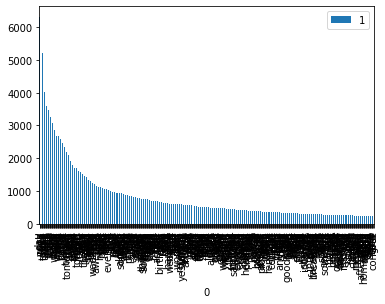

In [19]:
tu.plot.bar(x=0,y=1)

In [ ]:
hola

,0,1
0,0,user
1,1,ment
2,2,wellnot
3,3,breakup
4,4,speech
...,...,...
81787,81787,liqz
81788,81788,quotanni
81789,81789,retardlolwhat
81790,81790,cloudsit


In [20]:
sequences = tokenizer.texts_to_sequences(data_set_1.text)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[  0   0   0 ...   1  73  52]
 [  0   0   0 ... 414 614 346]
 [  0   0   0 ... 231   3  38]
 ...
 [  0   0   0 ... 309 685 376]
 [  0   0   0 ...   0 203 180]
 [  0   0   0 ...   0 859   7]]


SEPARAMOS TRAIN, TEST

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data_set_1.target.values, test_size=0.3, random_state=23042021)

In [32]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (70000, 21)
y_train (70000,)
X_test (30000, 21)
y_test (30000,)


In [33]:
y_train = np.where(y_train==4,1,y_train)
y_test = np.where(y_test==4,1,y_test)

In [25]:
y_train
y_test

array([0, 1, 1, ..., 0, 1, 0])

MODELADO

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1

In [36]:
# Crea una red con layers Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=64, trainable=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=82, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 21, 64)            64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 82)                5330      
_________________________________________________________________
dropout_5 (Dropout)          (None, 82)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 83        
Total params: 102,437
Trainable params: 102,437
Non-trainable params: 0
________________________________________________

In [37]:
# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [38]:
#%%timeit

# Train it
history_1 = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
3500/3500 [==============================] - 45s 12ms/step - loss: 0.5860 - binary_accuracy: 0.6801 - accuracy: 0.6801 - val_loss: 0.5292 - val_binary_accuracy: 0.7305 - val_accuracy: 0.7305
Epoch 2/20
3500/3500 [==============================] - 42s 12ms/step - loss: 0.5116 - binary_accuracy: 0.7496 - accuracy: 0.7496 - val_loss: 0.5138 - val_binary_accuracy: 0.7447 - val_accuracy: 0.7447
Epoch 3/20
3500/3500 [==============================] - 43s 12ms/step - loss: 0.5007 - binary_accuracy: 0.7536 - accuracy: 0.7536 - val_loss: 0.5147 - val_binary_accuracy: 0.7440 - val_accuracy: 0.7440
Epoch 4/20
3500/3500 [==============================] - 43s 12ms/step - loss: 0.4861 - binary_accuracy: 0.7631 - accuracy: 0.7631 - val_loss: 0.5200 - val_binary_accuracy: 0.7472 - val_accuracy: 0.7472
Epoch 5/20
3500/3500 [==============================] - 44s 12ms/step - loss: 0.4801 - binary_accuracy: 0.7652 - accuracy: 0.7652 - val_loss: 0.5159 - val_binary_accuracy: 0.7447 - val_accurac

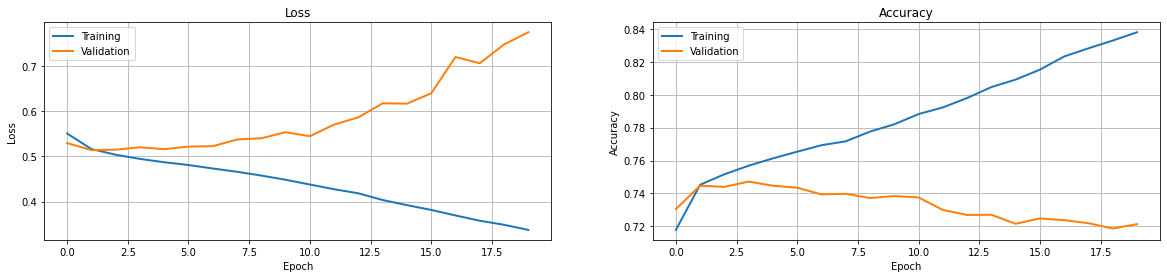

In [39]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history_1.history['loss'], label='Training', linewidth=2)
plt.plot(history_1.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history_1.history['accuracy'], label='Training', linewidth=2)
plt.plot(history_1.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [40]:
# Evaluate on test set
model.evaluate(x=X_test, y=y_test)

938/938 [==============================] - 5s 5ms/step - loss: 0.7952 - binary_accuracy: 0.7192 - accuracy: 0.7192


[0.7951760292053223, 0.7191666960716248, 0.7191666960716248]